# Are there returns to risk taking in science, philanthropy, or public policy?

If you're hoping to do good in the world, it makes sense to ask where your efforts will make the biggest impact.  Some have claimed that high risk projects with the potential for high returns are most promising because those areas are less crowded.  For example, here's a quote from Robert Reich's [essay](http://bostonreview.net/forum/foundations-philanthropy-democracy) on the role of philanthropic foundations in society: 

> When it comes to the ongoing work of experimentation, foundations have a structural advantage over market and state institutions: a longer time horizon. Once more, the lack of accountability may be a surprising advantage. Commercial entities in the marketplace do not have an incentive structure that systematically rewards high-risk, long time horizon experimentation; they need to show quarterly results. Similarly, public officials in a democracy do not have an incentive structure that rewards high-risk, long time horizon experimentation; they need to show results quickly from the expenditure of public dollars in order to get re-elected. In contrast, foundations are not subject to earnings reports, impatient investors or stockholders, or short-term election cycles.

> Foundations, answerable only to the diverse preferences and ideas of their donors, with a protected endowment permitted to exist in perpetuity, may be uniquely situated to engage in the sort of high-risk, long-run policy innovation and experimentation that is healthy in a democratic society.

The Open Philanthropy Project outlines a similar approach in [a post](https://www.openphilanthropy.org/blog/hits-based-giving) about their giving philosophy: 

> One of our core values is our tolerance for philanthropic “risk.” Our overarching goal is to do as much good as we can, and as part of that, we’re open to supporting work that has a high risk of failing to accomplish its goals. We’re even open to supporting work that is more than 90% likely to fail, as long as the overall expected value is high enough.

It seems [intuitive](https://blog.givewell.org/2013/05/02/broad-market-efficiency/) that there are returns to risk taking but I was wondering if there were any datasets out there that would support this idea.  Below I attempt to answer this question by looking at evidence from science, philanthropy, and public policy.   


## Definitions

Before I continue, I think it makes sense to define the terms **risk** and **return**.  By **return**, I mean the impact of an intervention using units like [disability adjusted life years](https://en.wikipedia.org/wiki/Disability-adjusted_life_year) per dollar, benefit to cost ratios, or research citation counts.  While some of these estimates are more complicated to construct than others, they all require making judgements about things like the value of a human life, the amount of suffering caused by different conditions, or the benefits from a highly cited paper.  

The definition of the term **risk** is tricky to pin down.  To some, it's just a measure of the noisiness of an estimate and is measured using something like the [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation).  To others, an intervention is only risky when it could potentially underperform some target (e.g. [downside risk](https://en.wikipedia.org/wiki/Downside_risk)) or cause harm.  The best [definition](https://medium.com/guesstimate-blog/the-confusion-of-risk-vs-uncertainty-1c6cd512aa69) that I have found is that risk is the subset of uncertainty that underperforms a target outcome.  Because people seem to use risk and uncertainty interchangeably, and I think both are useful, I include both in my analysis where possible. 

I see the uncertainty and risk values useful for answering two separate but related questions:
1. Do we tend to be more uncertain about actions with high expected value?
2. Do actions with large expected value also have more potential to cause harm (or underperform the mean action)?  

If (1) is correct, I think this is useful to know because we can be more confident in taking actions even if they have a high error around the estimated impact.   If (2) is correct, it might be ok to take actions that often perform poorly or have the potential to cause harm if they still have a high expected impact.   

Here are how the values are calculated:

* `standard deviation = np.stdev(series)`

* `downside risk (semideviation) = np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size)`, where `t` is the mean intervention outcome.  

Finally, how do you determine if there is a **return to risk taking**?  One approach would be to run a linear regression through the data and see if it has a positive slope.  This is what I do for most of the sources below, but there's a problem with this approach.  To see why, imagine calculating the cost effectiveness of every possible action, including bogus things like lighting $1000 on fire.  You'd end up with a lot of useless interventions that would mess up the slope of the linear regression.  So another approach would be to just see if the frontier that encloses the top end of the estimates has a positive slope.  In Modern Portfolio Theory, this frontier is called the [efficient frontier](https://en.wikipedia.org/wiki/Efficient_frontier):

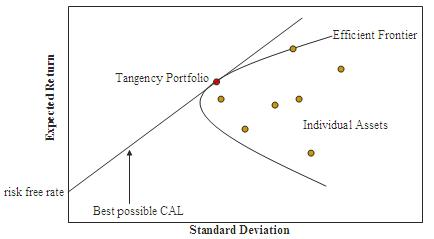 

I've written about this idea [before](https://github.com/psthomas/efficient-frontier) but didn't have the data to test the concept out until now.  I stick with linear regression for this notebook, but I run the data through a portfolio optimization algorithm to create an efficient frontier in the second notebook (`meta.ipynb`).  

## Data Sources 

It's pretty difficult to find datasets that quantify their uncertainty while also using a cross-intervention measure of impact, so it's taken me awhile to stumble across enough data to complete this analysis.  The scrape.py file included in this repo outlines how I accessed and cleaned data from each source.  
  

In [3]:
%matplotlib inline

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib

#pd.set_option('display.max_rows', 15)
matplotlib.style.use('ggplot')

/Users/psthomas/miniconda2/envs/datascience3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Evidence from Public Policy

First, I look at a dataset from the [Washington State Institute for Public Policy](http://www.wsipp.wa.gov/BenefitCost) (WSIPP).  The WSIPP evaluates evidence based public policies and completes detailed benefit-cost analyses using monte carlo methods.  The end result is a list of benefit-cost ratios along with metrics like the chance that the benefit-cost ratio is positive. 

The measure of risk I'm using here (`the chance costs exceed benefits`) sets a really low bar.  This ignores the upside of an intervention and much of the downside until the benefit cost ratio is below one.  It also counts a project with a very low downside the same of one with only a marginally low downside because they're just counting up benefit-cost ratios > 1 and [dividing by the total number of monte carlo runs](http://www.wsipp.wa.gov/TechnicalDocumentation/WsippBenefitCostTechnicalDocumentation.pdf).  The upside of this metric is that it is easy to interpret, but I wish they would include a standard deviation as well.         

In [4]:
#Helper function for viewing df
def ends(df, x=5):
    fill = ['...' for i in range(len(df.columns))]
    fill_df = pd.DataFrame([fill], columns=list(df))
    return df.head(x).append(fill_df).append(df.tail(x))

In [3]:
wa_df = pd.read_csv('./data/wa_data.csv')

sort_df = wa_df.sort_values('benefit_cost_ratio', ascending=True).reset_index(drop=True)

sort_df[['program_name', 'benefit_cost_ratio', 'chance_costs_exceed_benefits']]

,program_name,benefit_cost_ratio,chance_costs_exceed_benefits
0,Educator professional development: Use of data...,-174.30,69
1,Scared Straight,-101.25,98
2,Behavioral self-control training -BSCT,-80.03,77
3,Alcohol Literacy Challenge -for college students,-34.25,51
4,InShape,-29.59,53
5,Drug Abuse Resistance Education -D.A.R.E.,-7.71,51
6,Youth advocacy/empowerment programs for tobacc...,-7.13,64
7,Sex offender registration and community notifi...,-5.14,67
8,Interventions to prevent excessive gestational...,-5.03,64
9,Interventions to prevent excessive gestational...,-3.71,53


Below is a plot of the intervention rank and the benefit-cost ratio.  It's clear that some interventions outperform others by a few orders of magnitude.  Another intersting finding is that the distribution might be two tailed, with some outlying performers on the bad end as well.   

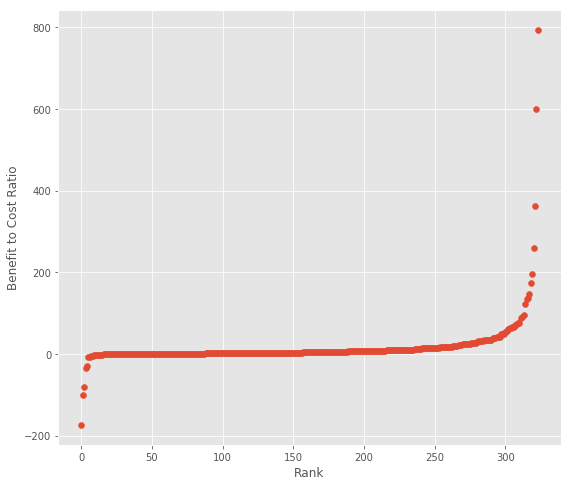

In [4]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Benefit to Cost Ratio')
plt.scatter(x=sort_df.index, y=sort_df['benefit_cost_ratio'])
plt.show()

Next, I plot the chance costs exceed benefits (an imperfect proxy for downside risk) against the benefit-cost ratio.  I derive the `chance costs exceed benefits` from WSIPP's `chance benefits exceed costs`  value, which they calculate by counting results from their monte carlo simulations.  This measure doesn't take into account the scale of good/poor performance, but it's the best we can get without access to their models.

The end result is that there doesn't seem to be much of a return to this measure of risk.    

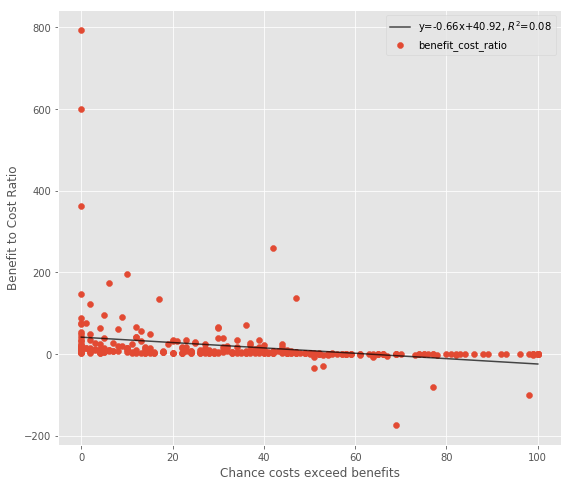

In [5]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(wa_df['chance_costs_exceed_benefits'], wa_df['benefit_cost_ratio'])
ax.set_xlabel('Chance costs exceed benefits')
ax.set_ylabel('Benefit to Cost Ratio')

x = pd.DataFrame({'chance_costs_exceed_benefits': np.linspace(wa_df['chance_costs_exceed_benefits'].min(),
                                            wa_df['chance_costs_exceed_benefits'].max(), 100)})

poly_1 = smf.ols(formula='benefit_cost_ratio ~ 1 + chance_costs_exceed_benefits',
                 data=wa_df, missing='drop').fit()

plt.plot(x, poly_1.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_1.rsquared,
                                                  poly_1.params.chance_costs_exceed_benefits,
                                                  poly_1.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

# Evidence from Public Health

The next dataset I look it is from the [Disease Control Priorities Project](http://www.dcp-3.org/dcp2) (DCP2), which comes up with comprehensive estimates of the cost effectiveness of different treatments in developing countries.  The original source is a table in the DCP2 report, which Jeff Kaufmann made into a [CSV](https://www.jefftk.com/dcp2.csv).  I selected the interventions with `$/DALY` units, eliminated any with zero or near zero spread (because they likely came from the same estimate), and only selected the estimates from sub-saharan Africa. Finally I coverted `$/DALY` units to `DALY/1000USD` so a bigger number has a higher impact.  

Using the spread isn't very rigorous and might bias the results towards understudied areas with few estimates (e.g. an intervention with only a single estimate has spread of 0), but it's the only measure of uncertainty available here.  

In [6]:
ph_df = pd.read_csv('./data/DCP2_data.csv')
ph_df = ph_df.apply(pd.to_numeric, errors='ignore')
ph_df.rename(columns={'Spread(DALY/1000USD)': 'spread', 
                      'cost_effectiveness(DALY/1000USD)': 'cost_effectiveness'}, 
             inplace=True)

ph_df[['condition', 'intervention',
       'cost_effectiveness', 'spread']].sort_values('cost_effectiveness', ascending=False)

,condition,intervention,cost_effectiveness,spread
29,Malaria,Intermittent preventive treatment in pregnancy...,142.857143,111.111111
28,Malaria,Insecticidetreated bednets,90.909091,83.333333
2,Lymphatic filariasis,Annual mass drug administration,66.666667,43.478261
41,Malaria,Residual household spraying,58.823529,66.666667
30,Malaria,Intermittent preventive treatment in pregnancy...,52.631579,90.909091
27,Traffic accidents,"Increased speeding penalties, enforcement, med...",47.619048,28.571429
16,Lymphatic filariasis,Diethyl carbamazine salt,45.454545,23.809524
39,HIV/AIDS,Peer and education programs for high-risk groups,27.027027,16.129032
52,HIV/AIDS,Voluntary counseling and testing,21.276596,13.333333
9,Tuberculosis (endemic),BCG vaccine,14.705882,37.037037


These estimates follow a similar pattern to the WSIPP data, with the top interventions a few orders of magnitude better than the worst.  

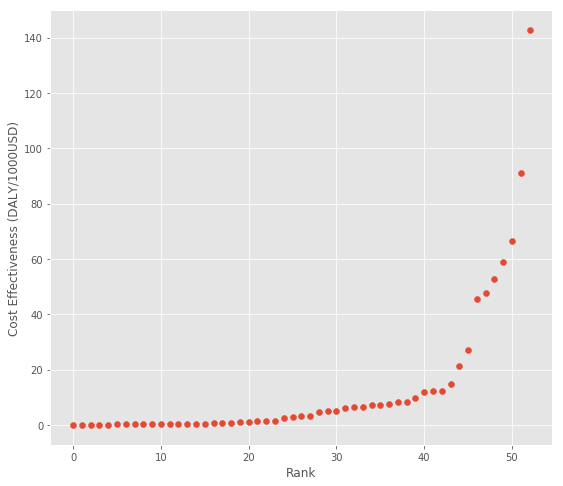

In [7]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')
sort_df = ph_df.sort_values('cost_effectiveness', ascending=True).reset_index(drop=True)
plt.scatter(x=sort_df.index, y=sort_df['cost_effectiveness'])
plt.show()

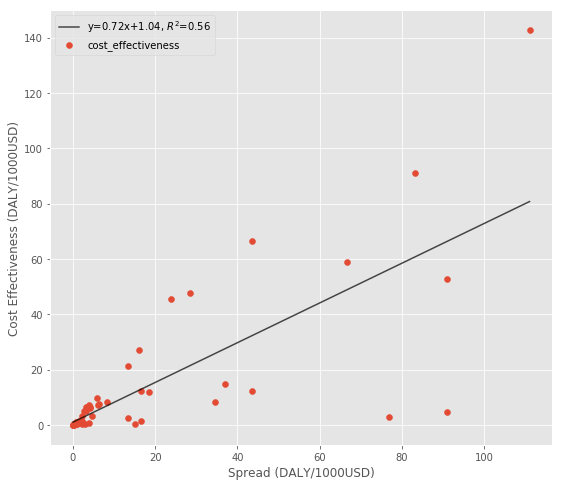

In [8]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(ph_df['spread'], ph_df['cost_effectiveness'])
ax.set_xlabel('Spread (DALY/1000USD)')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'spread': np.linspace(ph_df['spread'].min(),
                                            ph_df['spread'].max(), 100)})

poly_2 = smf.ols(formula='cost_effectiveness ~ 1 + spread',
                 data=ph_df, missing='drop').fit()

plt.plot(x, poly_2.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_2.rsquared,
                                                  poly_2.params.spread,
                                                  poly_2.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

So it seems there might be returns to risk taking when using the spread as the (somewhat imperfect) measure of risk.

A second dataset I found is from [a meta-analysis](https://academic.oup.com/jpubhealth/article/34/1/37/1554654) that looked at the cost effectiveness of public health interventions within the English National Health Service (NHS) [11].  This dataset is similar to the DCP2 data above because the only measure of uncertainty is the spread of the estimates.  Overall, there seems to be a similar but weaker pattern here.    

In [9]:
# Cleaning the data
# nice_df = pd.read_csv('./data/nice_data_raw.csv')

# nice_df.rename(columns={'Range (£) (minimum–maximum)': 'range', 
#     'Median cost/QALY (£)': 'median', 
#     'Number of estimates included in median ': 'num_estimates', 
#     'Comparator': 'comparator', 
#     'Guidance topic classification': 'guidance_topic'}, 
#     inplace=True)

# nice_df['median'] = nice_df['median'] \
#     .str.replace(pat=' ', repl='', regex=True)
# nice_df['range'] = nice_df['range'] \
#     .str.replace(pat=' ', repl='', regex=True)

# nice_df.to_csv('./data/nice_data.csv', index=False)

In [10]:
nice_df = pd.read_csv('./data/nice_data.csv', na_filter = False)

nice_df = nice_df[(nice_df['range'] != 'NA') & 
                  (nice_df['range'] != 'N/A') &
                  (nice_df['median'] != 'N/A')]

nice_df['spread'] = nice_df['range'] \
    .str.split('–') \
    .apply(lambda x: abs(int(x[0]) - int(x[1])))

nice_df = nice_df.apply(pd.to_numeric, errors='ignore')

del nice_df['range']

#Invert so large numbers are better, convert to QALY/1000£
nice_df['spread'] = (1/nice_df['spread'])*1000
nice_df['median'] = (1/nice_df['median'])*1000

nice_df.sort_values(by='median', ascending=False)

,guidance_topic,comparator,median,num_estimates,spread
53,Smoking cessation—general population: client c...,Background quit rate; no intervention or usua...,20.000000,8.0,2.288330
4,Exercise prescriptions,Advice,12.987013,4.0,7.194245
56,Smoking cessation—general population: recruitm...,Background quit rate; no intervention or advice,3.846154,15.0,0.074499
62,Smoking cessation —general population: dentist...,Usual care,3.311258,3.0,10.989011
51,Smoking cessation—general population: incentiv...,Intervention no NRT,2.793296,2.0,1.597444
2,BA (5 min plus self-help),Background quit rate,2.702703,8.0,1.801802
54,Smoking cessation—general population: proactiv...,Usual care or intervention but no telephone c...,2.341920,9.0,0.683527
58,Smoking cessation—general population: identify...,No intervention,1.984127,4.0,0.243902
61,Smoking cessation—general population: pharmaci...,Usual care,1.831502,2.0,4.608295
0,BA only (5 min),Background quit rate,1.366120,8.0,0.909091


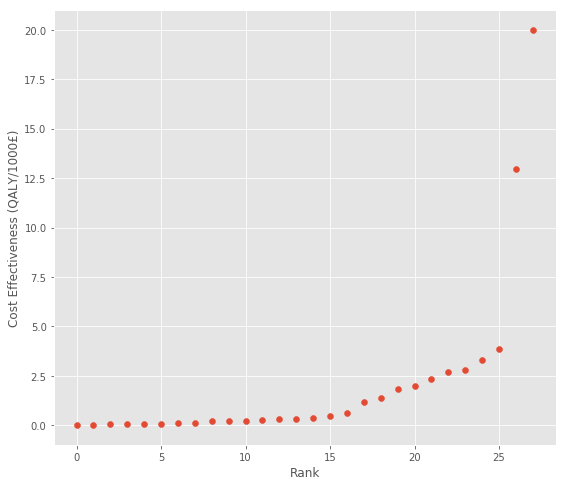

In [11]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Cost Effectiveness (QALY/1000£)')
sort_df = nice_df.sort_values('median', ascending=True).reset_index(drop=True)
plt.scatter(x=sort_df.index, y=sort_df['median'])
plt.show()

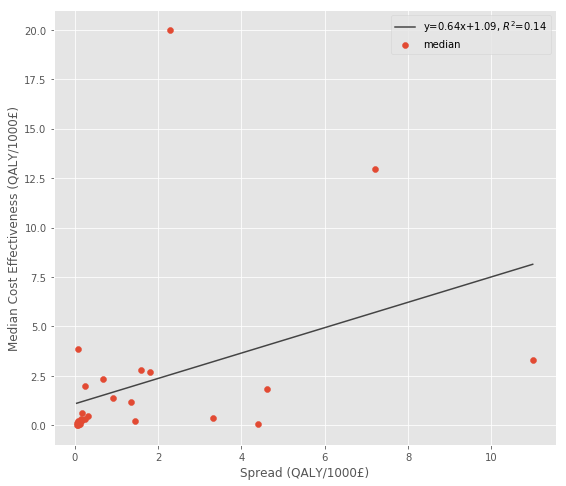

In [12]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(nice_df['spread'], nice_df['median'])
ax.set_xlabel('Spread (QALY/1000£)')
ax.set_ylabel('Median Cost Effectiveness (QALY/1000£)')

x = pd.DataFrame({'spread': np.linspace(nice_df['spread'].min(),
                nice_df['spread'].max(), 100)})

poly_0 = smf.ols(formula='median ~ 1 + spread',
                 data=nice_df, missing='drop').fit()

plt.plot(x, poly_0.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_0.rsquared,
                                                  poly_0.params.spread,
                                                  poly_0.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

Finally, I look at a massive dataset from the [Global Health Cost Effectiveness Analysis Registry](http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/) (GHCEA).  First, I look at the full distribution of cost effectiveness estimates.  It's pretty clear they're lognormally distributed.      

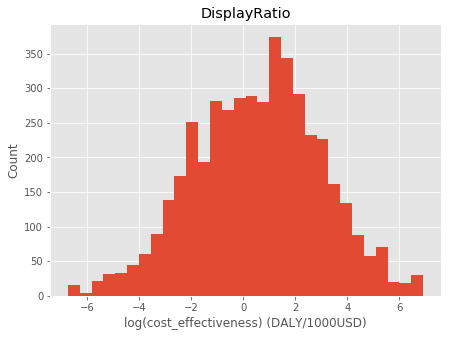

In [27]:
ghcea_df = pd.read_csv('./data/GHCEA_data.csv')

#Remove non-integer rows, convert to floats, convert to DALY/1000USD, take log
ghcea_df = ghcea_df[ghcea_df['DisplayRatio'].apply(lambda x: str(x).isdigit())]
ghcea_df['DisplayRatio'] = ghcea_df['DisplayRatio'].astype(float)
ghcea_df = ghcea_df[ghcea_df['DisplayRatio'] != 0] #Remove infinites
ghcea_df['DisplayRatio'] = (1/ghcea_df['DisplayRatio'])*1000
ghcea_df['DisplayRatio'] = np.log(ghcea_df['DisplayRatio'])

fig, ax = plt.subplots(figsize=(7,5))
ghcea_df.hist(column='DisplayRatio', bins=30, ax=ax)
ax.set_xlabel('log(cost_effectiveness) (DALY/1000USD)')
ax.set_ylabel('Count')
plt.show()

In [6]:
# interval_df.groupby('Rating').agg({'ArticleID':'count'})
# interval_df.groupby('CI_Currency').agg({'ArticleID':'count'})

Next, I look at just the estimates that have confidence intervals, which ends up being about 900 out of the 5000 original estimates.  The confidence interval column was too erratic, so I went through by hand and found the upper and lower bound.  I also filtered out studies with an overall quality rating below 4.5 (on a 1-7 scale).  The end result is 653 estimates that have confidence intervals.      

In [23]:
interval_df = pd.read_csv('./data/GHCEA_manualintervals.csv')

#Remove non-integer rows
interval_df  = interval_df[interval_df['DisplayRatio'].apply(lambda x: str(x).isdigit())]
#Convert to floats
interval_df['DisplayRatio'] = interval_df['DisplayRatio'].astype(float)
#Eliminate non-usable CIs
interval_df = interval_df[interval_df['CI_Usable'] == 1]
#Just use USD for now, because conversion ratio at time is unknown for others
# Only 9 AUD, 1 EUR filtered out
interval_df = interval_df[interval_df['CI_Currency'] == 'USD']
#Convert to DALY/1000USD
interval_df['DisplayRatio'] = (1/interval_df['DisplayRatio'])*1000
interval_df['CI_Difference'] = (1/interval_df['CI_Difference'])*1000
#Remove non standard CIs
interval_df = interval_df[(~interval_df['CI_Type'].isin(['INR', 'IQR']))]
#Also remove studies with quality rating lower than 4.5 out of 7:
interval_df = interval_df[interval_df['Rating'] >= 4.5] #4 

interval_df[['InterventionPhrase', 'DisplayRatio', 'CI_Difference']] \
    .sort_values(by='DisplayRatio', ascending=False)

,InterventionPhrase,DisplayRatio,CI_Difference
564,Preventive treatment of malaria in pregnancy w...,1000.000000,327.868852
846,Routine measles-containing vaccine followed by...,1000.000000,714.285714
413,Aspirin alone (325 mg initial dose & subsequen...,1000.000000,1612.903226
921,New tuberculosis vaccine (40% efficacy),1000.000000,925.925926
571,Preventive treatment of malaria in pregnancy w...,1000.000000,13.123360
514,Syphilis screening before third trimester + tr...,500.000000,250.000000
338,Intermittent preventive treatment in infants (...,333.333333,250.626566
523,Syphilis screening before third trimester + tr...,333.333333,142.857143
887,Brief smoking cessation advice + Bupropion,333.333333,0.057743
912,Syphilis screening before third trimester + tr...,333.333333,200.000000


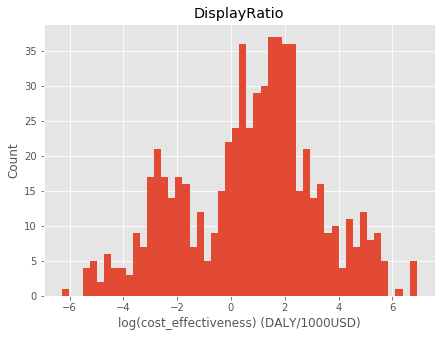

In [28]:
fig, ax = plt.subplots(figsize=(7,5))

temp_df = interval_df.copy()
temp_df['DisplayRatio'] = np.log(temp_df['DisplayRatio'])
temp_df[np.isfinite(temp_df['DisplayRatio'])].hist(
    column='DisplayRatio', bins=50, ax=ax)

ax.set_xlabel('log(cost_effectiveness) (DALY/1000USD)')
ax.set_ylabel('Count')
plt.show()

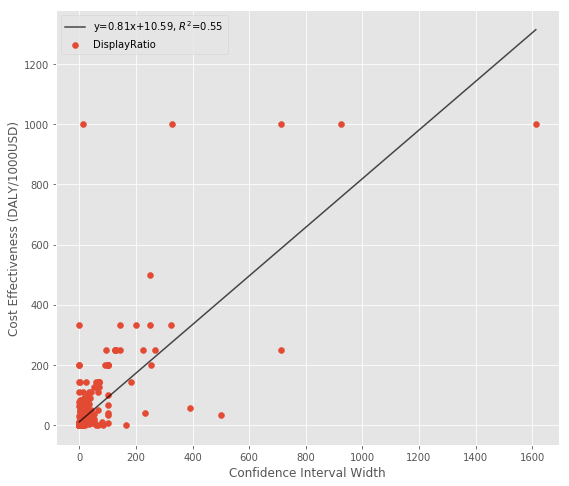

In [18]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(interval_df['CI_Difference'], interval_df['DisplayRatio'])
ax.set_xlabel('Confidence Interval Width')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')

# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_ylim(0.001, 2000)

x = pd.DataFrame({'CI_Difference': np.linspace(interval_df['CI_Difference'].min(),
    interval_df['CI_Difference'].max(), 100)})

poly_1 = smf.ols(formula='DisplayRatio ~ 1 + CI_Difference',
                 data=interval_df, missing='drop').fit()

plt.plot(x, poly_1.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_1.rsquared,
                                                  poly_1.params.CI_Difference,
                                                  poly_1.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

# Evidence from Philanthropy

Givewell is an organization that does in-depth charity evaluations, often using cost effectiveness estimates in their decision process.  They've recently changed their approach to [explicitly accomodate](https://www.givewell.org/how-we-work/our-criteria/cost-effectiveness/cost-effectiveness-models) different philosophical positions, but the [older models](https://docs.google.com/spreadsheets/d/1KiWfiAGX_QZhRbC9xkzf3I8IqsXC5kkr-nwY_feVlcM/edit#gid=2064365103) had their staff estimate different parameters for direct input.  

Dan Wahl had the [good idea](https://danwahl.github.io/stochastic-altruism) to run a monte carlo simulation by sampling from these staff parameters, which results in a set of estimates you can use to calculate the standard deviation and downside risk for an intervention.  I downloaded [his code](https://github.com/danwahl/stochastic-altruism) and put the combined outputs into `gw_data.csv` (see scrape.py), which I import below.  

In [14]:
gw_df = pd.read_csv('./data/gw_data.csv')

# Mean of the monte carlo intervention means:
t = gw_df.agg('mean').mean()

def downside_risk(series):
    return np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size)

gw_df = gw_df.agg(['mean', 'std', downside_risk]).T

gw_df.sort_values(by='mean', ascending=False)

,mean,std,downside_risk
iodine,41.418910,41.364215,1.438643
dtw,12.039437,11.307934,3.733827
sci,9.064981,8.657475,4.589170
ss,4.894470,4.598517,6.279625
lead,4.519663,14.533890,9.365194
bednets,3.572679,2.964297,6.958995
smc,3.222606,2.162316,7.082046
cash,1.060328,0.380961,8.921943


The cost effectiveness rankings here follow a similar pattern to the other datasets, although it's a little less pronounced:  

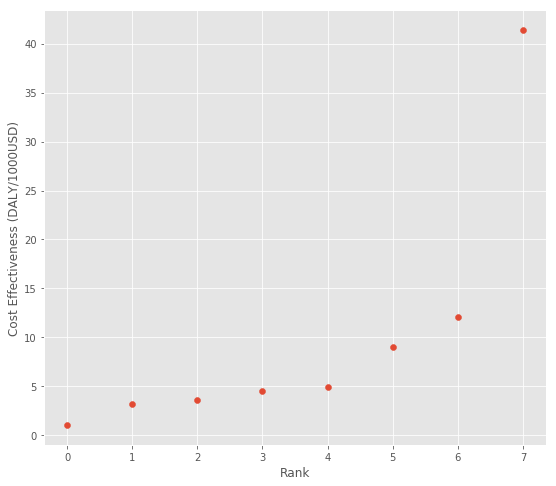

In [15]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')
sort_df = gw_df.sort_values('mean', ascending=True).reset_index(drop=True)
plt.scatter(x=sort_df.index, y=sort_df['mean'])
plt.show()

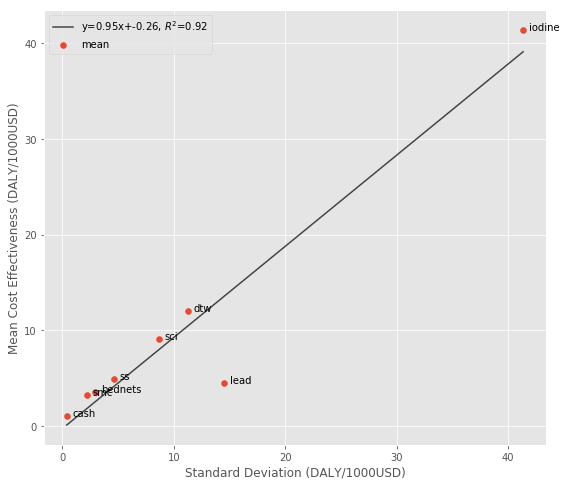

In [16]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(gw_df['std'], gw_df['mean'])
ax.set_xlabel('Standard Deviation (DALY/1000USD)')
ax.set_ylabel('Mean Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'std': np.linspace(gw_df['std'].min(),
                                            gw_df['std'].max(), 100)})

poly_3 = smf.ols(formula='mean ~ 1 + std',
                 data=gw_df, missing='drop').fit()

plt.plot(x, poly_3.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_3.rsquared,
                                                  poly_3.params['std'],
                                                  poly_3.params.Intercept), alpha=0.7)  
for i, txt in enumerate(gw_df.index):
    ax.annotate(txt, (gw_df['std'][i]+0.5, gw_df['mean'][i]))

plt.legend()
plt.show()

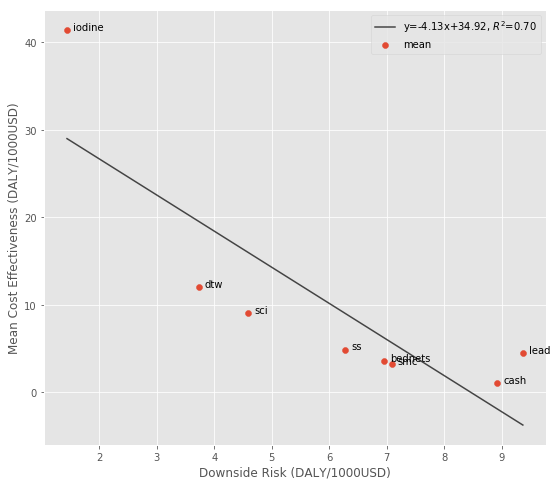

In [17]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(gw_df['downside_risk'], gw_df['mean'])
ax.set_xlabel('Downside Risk (DALY/1000USD)')
ax.set_ylabel('Mean Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'downside_risk': np.linspace(gw_df['downside_risk'].min(),
                                            gw_df['downside_risk'].max(), 100)})

poly_4 = smf.ols(formula='mean ~ 1 + downside_risk',
                 data=gw_df, missing='drop').fit()

plt.plot(x, poly_4.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_4.rsquared,
                                                  poly_4.params['downside_risk'],
                                                  poly_4.params.Intercept), alpha=0.7)  
for i, txt in enumerate(gw_df.index):
    ax.annotate(txt, (gw_df['downside_risk'][i]+ 0.1, gw_df['mean'][i]))  

plt.legend()
plt.show()

So if you prefer to use the standard deviation as a measure, there do seem to be returns to risk taking -- higher impact estimates tend to be noisier.  But if the downside risk makes more sense to you, the lowest impact interventions underperform the mean to a greater extent.    

# Evidence from Scientific Research

I have two sources of data on the impact of scientific research.  The first is from the Future of Humanity Institute's (FHI) [research](http://www.fhi.ox.ac.uk/research-into-neglected-diseases/) looking at the long term impact of  neglected tropical disease research.  The second is data I collected from Google Scholar on the variation in citation counts vs. mean citation counts for individual researchers. 

## FHI Estimates

These numbers differ from the GiveWell numbers above because they are estimates of the value of scientific research, and aren't derived from randomized control trials of existing treatments.  This means we should be much more [uncertain about this model](https://en.wikipedia.org/wiki/Uncertainty_quantification#Sources_of_uncertainty) and the inputs.  Below, I import the numbers I downloaded from their [spreadsheet](https://docs.google.com/spreadsheets/d/1yjgr0aiHTQF4i5jMy4Q-MI1TLWC6sMoS14MorZc6nNw/edit#gid=6), calculate the standard deviation, and then sample from the distributions to calculate the downside risk.  

In [18]:
fhi_df = pd.read_csv('./data/fhi_data.csv')
# Convert sigma to stdev, still meaningful for non-normal distributions:
# https://en.wikipedia.org/wiki/Log-normal_distribution
# https://en.wikipedia.org/wiki/Chebyshev's_inequality
# https://stats.stackexchange.com/questions/173715
fhi_df['stdev'] = np.sqrt((np.exp(fhi_df['sigma'])**2 - 1) * fhi_df['mean']**2)  


In [19]:
t = fhi_df['mean'].mean()

def downside_risk(series):
    return np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size)

#Sample from probability distributions to generate downside risk estimates:
columns = fhi_df['disease']
samples = []
n = 10000
for i,r in fhi_df.iterrows():
    samples.append(np.random.lognormal(r['mu'], r['sigma'], n))

data = np.array(samples).transpose()
sample_df = pd.DataFrame(data, columns=columns)

sample_df = sample_df.agg(downside_risk).to_frame(name="downside_risk")
fhi_df = fhi_df.join(sample_df, on='disease')
fhi_df.sort_values(by='mean', ascending=False)

,group,disease,mu,sigma,median,mean,stdev,downside_risk
3,Diarrhoeal disease,Diarrhoeal diseases,-1.466692,4.391203,0.230687,3549.783221,286578.696559,633.989195
14,Meningitis,Meningititis,-2.503745,4.463425,0.081778,1732.527683,150346.122518,641.402456
11,Parasitic and vector diseases,Leishmaniasis,-3.706662,4.721702,0.024559,1703.723172,191421.556624,646.604046
17,Leprosy,Leprosy,-5.014960,4.843504,0.006638,824.521890,104639.483899,652.099806
13,Parasitic and vector diseases,Trypanosomiasis,-5.296044,4.895739,0.005011,802.785665,107344.569326,652.202271
1,Malaria,Malaria,-3.161076,4.437962,0.042380,801.655755,67817.253156,647.595664
16,Meningitis,Multiple salmonella infections,-1.895189,4.127971,0.150290,753.616047,46757.225910,641.249901
15,Meningitis,Typhoid and paratyphoid fever,-2.798470,4.327229,0.060903,709.092672,53697.852674,645.673434
12,Parasitic and vector diseases,Chagas disease,-4.955053,4.740730,0.007048,534.967344,61260.904879,652.317438
0,HIV,HIV,-3.783888,4.358867,0.022734,303.678832,23736.173393,650.248227


Again, these numbers follow the patterns of earlier estimates with some research topics substantially outperforming others:

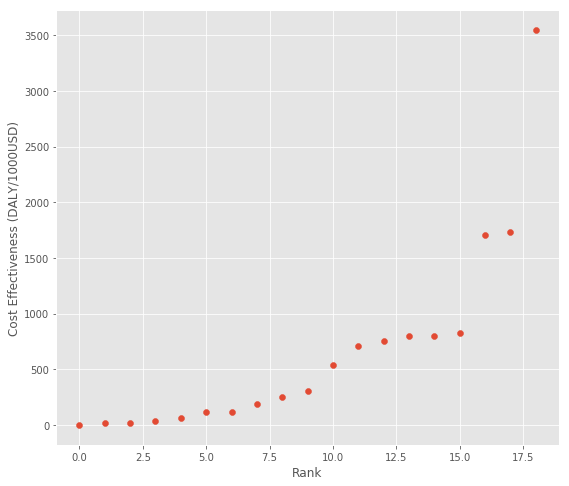

In [20]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')
sort_df = fhi_df.sort_values('mean', ascending=True).reset_index(drop=True)
plt.scatter(x=sort_df.index, y=sort_df['mean'])
plt.show()

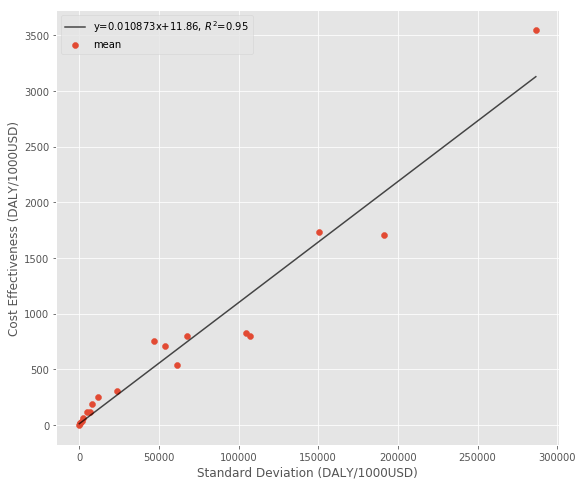

In [21]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(fhi_df['stdev'], fhi_df['mean'])
ax.set_xlabel('Standard Deviation (DALY/1000USD)')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'stdev': np.linspace(fhi_df['stdev'].min(),
                                       fhi_df['stdev'].max(), 100)})

poly_5 = smf.ols(formula='mean ~ 1 + stdev',
                 data=fhi_df, missing='drop').fit()

plt.plot(x, poly_5.predict(x), 'k-',
         label='y={1:.6f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_5.rsquared,
                                                  poly_5.params.stdev,
                                                  poly_5.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

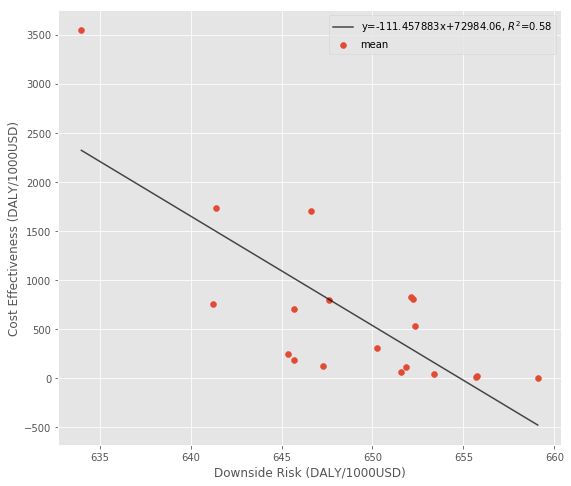

In [22]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(fhi_df['downside_risk'], fhi_df['mean'])
ax.set_xlabel('Downside Risk (DALY/1000USD)')
ax.set_ylabel('Cost Effectiveness (DALY/1000USD)')

x = pd.DataFrame({'downside_risk': np.linspace(fhi_df['downside_risk'].min(),
                                       fhi_df['downside_risk'].max(), 100)})

poly_6 = smf.ols(formula='mean ~ 1 + downside_risk',
                 data=fhi_df, missing='drop').fit()

plt.plot(x, poly_6.predict(x), 'k-',
         label='y={1:.6f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_6.rsquared,
                                                  poly_6.params.downside_risk,
                                                  poly_6.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

This is the first dataset that allows us to look at both the standard deviation and downside risk.  This shows us that while there is a strong positive relationship between uncertainty and impact, there is a weaker negative relationship between downside risk and impact.


## Research Citation Counts

Next, I thought it would be interesting to see if these patterns appear in researcher citation counts.  I found a list of ecology researchers along with links to their Google Scholar profiles on [GitHub](https://github.com/weecology/bibliometrics/blob/master/Google_ecology.csv).  I treated this list as a population of researchers (I'm not sure if it really is), then randomly selected 100 non-students and downloaded their list of publications and citation counts.  I then calculated the mean citation count, standard deviation, and downside risk for each researcher.     

The assumption here is that citation count is proportional to real world impact.  Another thing to mention is that these scientists have different funding levels, so we don't know the true funding to citation conversion rate.     

In [23]:
citation_df = pd.read_csv('./data/eco_citations.csv')
citation_df['citations'] = citation_df['citations'].str.replace('*','')
citation_df['citations'].fillna(0, inplace=True)
citation_df = citation_df.apply(pd.to_numeric, errors='ignore')

In [24]:
#t = citation_df['citations'].mean()  # Mean paper, not mean researcher
t = citation_df.groupby('id').agg({'citations':'mean'}).mean()[0]  #Mean citations by researcher
# Mean paper: 48.59607438016529
# Mean researcher: 37.4092092357909

def downside_risk(series):
    return np.sqrt((np.minimum(0.0, series - t)**2).sum()/series.size) 

citation_df = citation_df.groupby(['id']).agg({'citations': ['mean', 'std', downside_risk]})

citation_df.columns = citation_df.columns.droplevel(0)

citation_df.head()

,mean,std,downside_risk
id,,,
30,78.092593,107.506958,19.496066
89,19.361702,17.013327,23.927285
129,17.962963,20.803996,25.888243
143,12.964286,19.114629,29.574690
145,3.500000,4.485018,34.183520


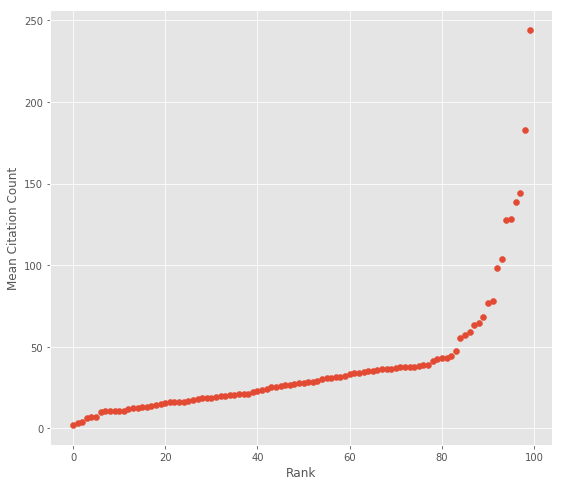

In [25]:
fig, ax = plt.subplots(figsize=(9,8))
ax.set_xlabel('Rank')
ax.set_ylabel('Mean Citation Count')
sort_df = citation_df.sort_values('mean', ascending=True).reset_index(drop=True)
plt.scatter(x=sort_df.index, y=sort_df['mean'])
plt.show()

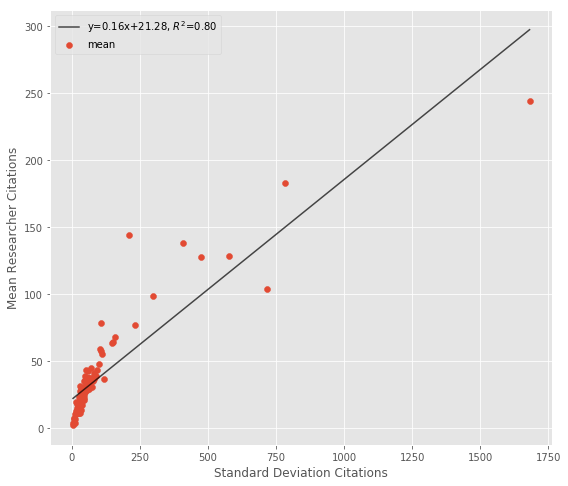

In [26]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(citation_df['std'], citation_df['mean'])
ax.set_xlabel('Standard Deviation Citations')
ax.set_ylabel('Mean Researcher Citations')

x = pd.DataFrame({'std': np.linspace(citation_df['std'].min(),
                                       citation_df['std'].max(), 100)})

poly_7 = smf.ols(formula='mean ~ 1 + std',
                 data=citation_df, missing='drop').fit()

plt.plot(x, poly_7.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_7.rsquared,
                                                  poly_7.params['std'],
                                                  poly_7.params.Intercept), alpha=0.7)  
plt.legend()
plt.show()

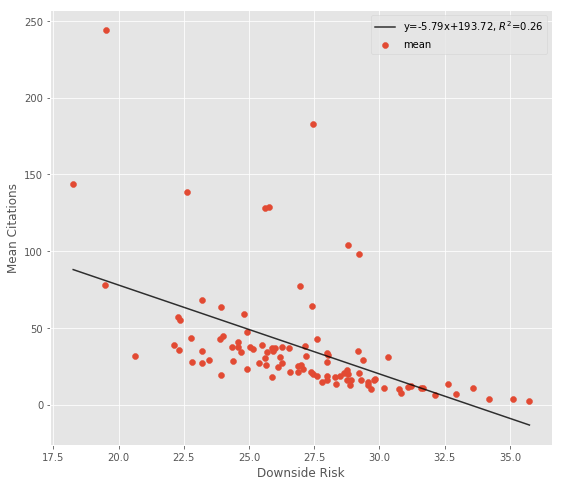

In [27]:
fig, ax = plt.subplots(figsize=(9,8))
plt.scatter(citation_df['downside_risk'], citation_df['mean'])
ax.set_xlabel('Downside Risk')
ax.set_ylabel('Mean Citations')

x = pd.DataFrame({'downside_risk': np.linspace(citation_df['downside_risk'].min(),
                                       citation_df['downside_risk'].max(), 100)})

poly_8 = smf.ols(formula='mean ~ 1 + downside_risk',
                 data=citation_df, missing='drop').fit()

plt.plot(x, poly_8.predict(x), 'k-',
         label='y={1:.2f}x+{2:.2f}, $R^2$={0:.2f}'.format(poly_8.rsquared,
                                                  poly_8.params['downside_risk'],
                                                  poly_8.params.Intercept), alpha=0.8)  
plt.legend()
plt.show()

Using the standard deviation in a situation like this doesn't make a lot of sense.  By default, a very successful researcher might have a high standard deviation in their citations as they progress in their career from lowly cited papers to highly cited papers.  I think the downside risk metric is more useful here, and it shows that highly cited researchers outperform the mean researcher more often.

# Conclusion

It's interesting to see some common patterns emerge across these different domains and datasets.   
* First, the impact distributions make it clear that some interventions are much better than others.  As a result, it makes sense to spend a lot of time searching for good opportunities.  
* Second, interventions with a high downside risk tend to have lower impacts.  Even though high impact interventions are more uncertain, they dip below the mean less often or to a lesser extent.   
* Third, there do seem to be returns to uncertainty, so a large error bound on a cost effectiveness estimate shouldn't be disqualifying on it's own.  

Whether or not there are returns to risk, then, depends on your definition of risk.  Using the definitions from the introduction, it makes more sense to say there are returns to uncertainty.  In other words, uncertainty is something you might have to learn to live with if you want to have a big effect on the world.  

# References

[1] *What Are Foundations For?* Boston Review.  [http://bostonreview.net/forum/foundations-philanthropy-democracy](http://bostonreview.net/forum/foundations-philanthropy-democracy)

[2] *Hits-based Giving.*  Open Philanthropy Project.  [https://www.openphilanthropy.org/blog/hits-based-giving](https://www.openphilanthropy.org/blog/hits-based-giving)

[3] *Broad market efficiency.*  GiveWell. [https://blog.givewell.org/2013/05/02/broad-market-efficiency/](https://blog.givewell.org/2013/05/02/broad-market-efficiency/)

[4] *The Confusion of Risk vs. Uncertainty.*  The Guesstimate Blog.  [https://medium.com/guesstimate-blog/the-confusion-of-risk-vs-uncertainty-1c6cd512aa69](https://medium.com/guesstimate-blog/the-confusion-of-risk-vs-uncertainty-1c6cd512aa69)

[5] *Benefit-Cost Results.*  Washington State Institute for Public Policy.  [http://www.wsipp.wa.gov/BenefitCost](http://www.wsipp.wa.gov/BenefitCost)

[6] *Disease Control Priorities in Developing Countries (DCP2).*  [http://www.dcp-3.org/dcp2](http://www.dcp-3.org/dcp2)

[7] *GiveWell's Cost-Effectiveness Analyses.*  GiveWell.  [https://www.givewell.org/how-we-work/our-criteria/cost-effectiveness/cost-effectiveness-models](https://www.givewell.org/how-we-work/our-criteria/cost-effectiveness/cost-effectiveness-models)

[8] *Stochastic Altruism.* [https://danwahl.github.io/stochastic-altruism](https://danwahl.github.io/stochastic-altruism)

[9] *Uncertainty Quantification.*  Wikipedia.  [https://en.wikipedia.org/wiki/Uncertainty_quantification#Sources_of_uncertainty](https://en.wikipedia.org/wiki/Uncertainty_quantification#Sources_of_uncertainty)

[10] *Chebyshev's Inequality.*  Wikipedia. [https://en.wikipedia.org/wiki/Chebyshev's_inequality](https://en.wikipedia.org/wiki/Chebyshev's_inequality)

[11] *The cost-effectiveness of public health interventions.*  Journal of Public Health.  [https://academic.oup.com/jpubhealth/article/34/1/37/1554654](https://academic.oup.com/jpubhealth/article/34/1/37/1554654)

[12] *The Global Health Cost Effectiveness Analysis Registry* Tufts University.  [http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/](http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/)

[13] *The Global Health Cost Effectiveness Analysis Registry* Tufts University.  [http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/](http://healtheconomics.tuftsmedicalcenter.org/ghcearegistry/)